# Code to run Classification models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('modeling_final_dataset.csv')
df_t = pd.read_csv('random_picked_songs.csv')

#### Additional Preprocessing 

In [5]:
def conv_to_obj(a):
    return str(int(a))

In [6]:
df['mode'] = df['mode'].apply(conv_to_obj)
df['time_signature'] = df['time_signature'].apply(conv_to_obj)
df['explicit'] = df['explicit'].apply(conv_to_obj)
df['key'] = df['key'].apply(conv_to_obj)

In [7]:
df = df.drop(['Unnamed: 0', 'pc1_popularity_index', 'album_name', 'artist', 'n_markets', 'track_name'], axis = 1)

In [20]:
df[df.bb_appear == 1].shape[0]/df[df.bb_appear == 0].shape[0]
# around 22% of the songs belong to the positive class

0.21750663129973474

### Modeling for existing artists & new - predicting billboard appearance


In [45]:
# Logistic Regression Classifier
def get_pred_logreg(X_train_res, y_train_res, X_test, y_test):
    
    hyperparameters = {
                        'C': np.logspace(0, 4, 10),
                        'penalty': ['l1', 'l2']
                        }
    
    log_reg = LogisticRegression()
    clf = GridSearchCV(log_reg, hyperparameters, cv = 5, refit = True, scoring = 'accuracy')
    best_model = clf.fit(X_train_res, y_train_res)
    print('classes ', clf.classes_)
    #predicting the probabilities of the output being 0 or 1, will give us a 2 column vector
    y_pred = best_model.predict_proba(X_test)[:, 1]
    # creating the new dataframe which has the true and predicted values
    logreg_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})
    
    return [logreg_results, best_model.best_score_, best_model.best_params_]

In [46]:
# Support Vector Classifier
def get_pred_svm(X_train_res, y_train_res, X_test, y_test):
    hyperparameters = [{
                        'C': [1, 10, 100],
                        'kernel': ['linear']
                        },
                       {
                        'C': [1, 10, 100],
                        'gamma': [0.5, 0.1, 0.01, 0.001],
                        'kernel': ['rbf']
                        }]

    # instantiating the Support Vector Machine Classifier
    svm_clf = SVC()
    clf = GridSearchCV(svm_clf, hyperparameters, cv = 5, refit = True, scoring = 'accuracy', n_jobs = -1)
    # fitting the model to the training set
    best_model = clf.fit(X_train_res, y_train_res) 
    print('classes ', clf.classes_)
    #predicting the probabilities of the output being 0 or 1, will give us a 2 column vector
    y_pred = best_model.predict_proba(X_test)[:, 1]
    # creating the new dataframe which has the true and predicted values
    svc_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})
    
    return [svc_results, best_model.best_score_, best_model.best_params_]

In [47]:
# Naive Bayes Classifier
def get_pred_nb(X_train_res, y_train_res, X_test, y_test):
    
    # instantiating the Support Vector Machine Classifier
    nb_clf = GaussianNB()
    # fitting the model to the training set
    nb_clf.fit(X_train_res, y_train_res) 
    # making predictions on the test set
    y_pred = nb_clf.predict_proba(X_test)[:, 1]
    # creating the new dataframe which has the true and predicted values
    nb_clf_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})
    
    return nb_clf_results, nb_clf.score, nb_clf.get_params

In [48]:
# K-Neighbors Classifier
def get_pred_knn(X_train_res, y_train_res, X_test, y_test):
    hyperparameters = {
                        'weights': ['uniform', 'distance'],
                        'n_neighbors': np.arange(1, 21),
                        }
    
    # instantiating the K Nearest Neighbors Classifier with k neighbors and a simple average voting scheme
    knn_clf = KNeighborsClassifier() 
    clf = GridSearchCV(knn_clf, hyperparameters, cv = 5, refit = True, scoring = 'accuracy', n_jobs = -1)
    # fitting the model to the training set
    best_model = clf.fit(X_train_res, y_train_res) 
    print('classes ', clf.classes_)
    #predicting the probabilities of the output being 0 or 1, will give us a 2 column vector
    y_pred = best_model.predict_proba(X_test)[:, 1]
    # creating the new dataframe which has the true and predicted values
    knn_clf_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})

    return [knn_clf_results, best_model.best_score_, best_model.best_params_]

In [49]:
# Random Forest Classifier
def get_pred_rfc(X_train_res, y_train_res, X_test, y_test):
    hyperparameters = {
                        'max_features': ['auto', 'sqrt', 'log2'],
                        'max_depth' : [4,5,6,7,8],
                        'criterion' :['gini', 'entropy']
                        }
    
    # instantiating the K Nearest Neighbors Classifier with k neighbors and a simple average voting scheme
    rf_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
    clf = GridSearchCV(rf_clf, hyperparameters, cv = 5, refit = True, scoring = 'accuracy', n_jobs = -1)
    # fitting the model to the training set
    best_model = clf.fit(X_train_res, y_train_res) 
    print('classes ', clf.classes_)
    #predicting the probabilities of the output being 0 or 1, will give us a 2 column vector
    y_pred = best_model.predict_proba(X_test)[:, 1]
    # creating the new dataframe which has the true and predicted values
    rf_clf_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})

    return [rf_clf_results, best_model.best_score_, best_model.best_params_]

In [50]:
# XGBoost classifier
def get_pred_xgb(X_train_res, y_train_res, X_test, y_test):

    hyperparameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 1.0],
        'max_depth': [3, 4, 5]
        }

    # instantiating the XGB classifier
    xgb_clf = XGBClassifier(learning_rate = 0.1, n_estimators = 400, objective = 'binary:logistic',
                    silent = True, nthread = 1)
    clf = GridSearchCV(xgb_clf, hyperparameters, cv = 5, refit = True, scoring = 'accuracy', n_jobs = -1)
    # fitting the model to the training set
    best_model = clf.fit(np.array(X_train_res), y_train_res) 
    print('classes ', clf.classes_)
    #predicting the probabilities of the output being 0 or 1, will give us a 2 column vector
    y_pred = best_model.predict_proba(np.array(X_test))[:, 1]
    # creating the new dataframe which has the true and predicted values
    xgb_clf_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})

    return [xgb_clf_results, best_model.best_score_, best_model.best_params_]

In [51]:
# Default model
def get_pred_default(X_train_res, y_train_res, X_test, y_test):
    
    # prediction of the default model is the label with the highest count
    vc = pd.Series(y_train.value_counts())
    list_1 = np.ones(len(y_test))
    y_pred = [int(x) * vc.idxmax() for x in list_1]    
    # creating the new dataframe which has the true and predicted values
    default_results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test})

    return default_results.astype(int)

In [52]:
# Function to compute classification metrics
def get_metrics(pred_df, cutoff = 0.5):
    # replacing the probabilities with the target labels
    pred_df['predictions_int'] = np.where(pred_df.predictions.values > cutoff, 1, 0)
    pred_df = pred_df.astype(int)
    # getting the confusion matrix    
    cf_mat = confusion_matrix(pred_df.true_output, pred_df.predictions_int)
    fig, ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cf_mat, annot = True, fmt = 'd', xticklabels = [0, 1], yticklabels = [0, 1])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    # getting the False Positives, False Negatives, True Positives and True Negatives
    FP = cf_mat.sum(axis = 0) - np.diag(cf_mat)  
    FN = cf_mat.sum(axis = 1) - np.diag(cf_mat)
    TP = np.diag(cf_mat)
    TN = cf_mat.sum() - (FP + FN + TP)
    df_metrics = pd.DataFrame()
    # storing the true positive rate, false positive rate, accuracy and precision in a dataframe
    df_metrics['tpr'] = TP / (TP + FN)
    df_metrics['fpr'] = FP / (FP + TN)
    df_metrics['accuracy'] = (TP + TN) / (TP + FP + FN + TN)
    df_metrics['precision'] = TP / (TP + FP)
    df_metrics['recall'] = TP / (TP + FN)
    df_metrics['F score'] = 2 * (df_metrics['precision'] * df_metrics['recall'])/(df_metrics['precision'] + df_metrics['recall'])
    
    print(df_metrics.loc[1])

In [64]:
# Function to plot the roc curves
def plot_roc(pred_df, cutoff = 0.5):
    fpr, tpr, thresholds = roc_curve(pred_df['true_output'], pred_df['predictions'], pos_label = 1)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize = (5, 5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [54]:
# function to scale and binarize the input features
def scale_and_binarize(df):
    cat_cols = df.select_dtypes(include = 'object')
    cat_cols = pd.get_dummies(cat_cols, drop_first = True)
    
    num_cols = df.select_dtypes(exclude = 'object')
    num_cols = pd.DataFrame(StandardScaler().fit_transform(num_cols), columns = num_cols.columns)
    
    df_t = pd.concat([num_cols, cat_cols], axis = 1)
    
    return df_t

In [55]:
def prepare_data(artist_type):
    # preapre the data differently based on whether we are trying to build models for new artists or existing artists
    if artist_type is 'existing':
        X = scale_and_binarize(df.drop(['bb_appear', 'weeks', 'album_popularity', 'track_popularity'], axis = 1))
        y = df['bb_appear']
    elif artist_type is 'new':
        X = scale_and_binarize(df.drop(['bb_appear', 'weeks', 'album_popularity', 'track_popularity', 'artist_followers', 'artist_popularity'], axis = 1))
        y = df['bb_appear']
    else:
        print("Invalid input. Use either 'existing' or 'new' as input")
        return
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    #oversampling to reduce imbalance
    sm = SMOTE(random_state = 12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    return X_train_res, y_train_res, X_test, y_test

In [60]:
# shuffle the input dataset
df = df.sample(frac = 1).reset_index(drop = True)

# get the source and target
X_train_res, y_train_res, X_test, y_test = prepare_data('new')

# evaluate the model
model_predictions = {
        #'knn_pred': get_pred_knn(X_train_res, y_train_res, X_test, y_test),
        #'logreg_pred': get_pred_logreg(X_train_res, y_train_res, X_test, y_test)
        #'svm_pred': get_pred_svm(X, y),
        #'nb_pred': get_pred_nb(X_train_res, y_train_res, X_test, y_test),
        'rfc_pred': get_pred_rfc(X_train_res, y_train_res, X_test, y_test),
        'xgb_pred': get_pred_xgb(X_train_res, y_train_res, X_test, y_test)
        #'default': get_pred_default(X, y)
    }

classes  [0 1]
classes  [0 1]


---------------Model:  rfc_pred --------------

CV Results on the training data data:
GCV best score:  0.8140729327170005 
GCV best parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'} 

Results on the hold-out test data:

Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



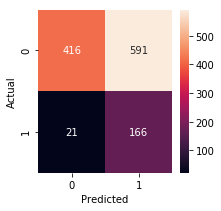

tpr          0.887701
fpr          0.586892
accuracy     0.487437
precision    0.219287
recall       0.887701
F score      0.351695
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



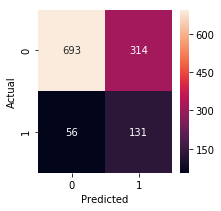

tpr          0.700535
fpr          0.311817
accuracy     0.690117
precision    0.294382
recall       0.700535
F score      0.414557
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



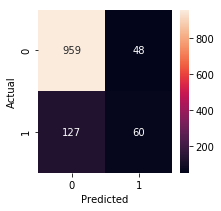

tpr          0.320856
fpr          0.047666
accuracy     0.853434
precision    0.555556
recall       0.320856
F score      0.406780
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.7 

Accuracy Metrics: 



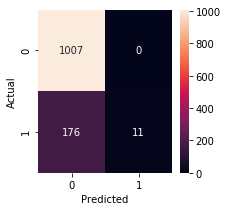

tpr          0.058824
fpr          0.000000
accuracy     0.852596
precision    1.000000
recall       0.058824
F score      0.111111
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.8 

Accuracy Metrics: 



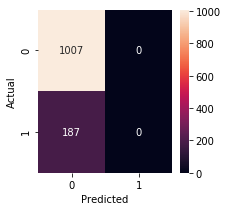

tpr          0.000000
fpr          0.000000
accuracy     0.843384
precision         NaN
recall       0.000000
F score           NaN
Name: 1, dtype: float64




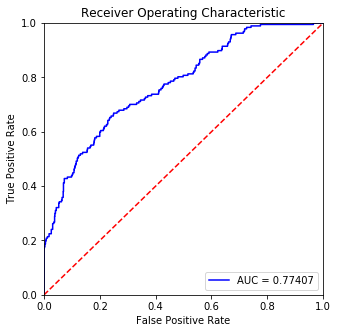

---------------Model:  xgb_pred --------------

CV Results on the training data data:
GCV best score:  0.9130713918849512 
GCV best parameters:  {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0} 

Results on the hold-out test data:

Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



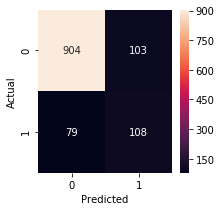

tpr          0.577540
fpr          0.102284
accuracy     0.847571
precision    0.511848
recall       0.577540
F score      0.542714
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



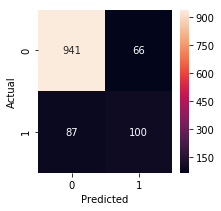

tpr          0.534759
fpr          0.065541
accuracy     0.871859
precision    0.602410
recall       0.534759
F score      0.566572
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



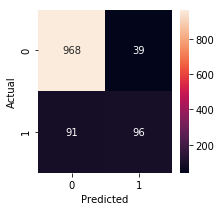

tpr          0.513369
fpr          0.038729
accuracy     0.891122
precision    0.711111
recall       0.513369
F score      0.596273
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.7 

Accuracy Metrics: 



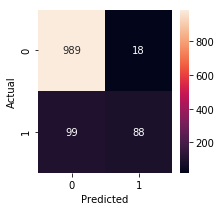

tpr          0.470588
fpr          0.017875
accuracy     0.902010
precision    0.830189
recall       0.470588
F score      0.600683
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.8 

Accuracy Metrics: 



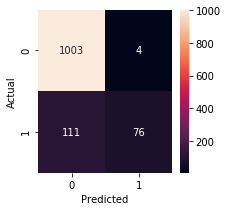

tpr          0.406417
fpr          0.003972
accuracy     0.903685
precision    0.950000
recall       0.406417
F score      0.569288
Name: 1, dtype: float64




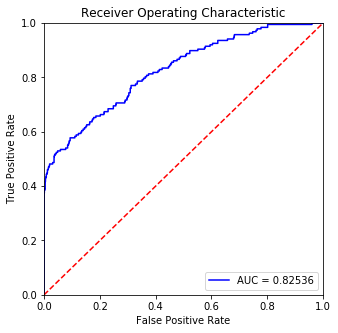

In [65]:
# This section evaluates the models for existing artists
    for key, value in model_predictions.items():
        print('---------------Model: ', key, "--------------\n")
        print('CV Results on the training data data:')
        print('GCV best score: ', value[1], "")
        print('GCV best parameters: ', value[2], "\n")
        print('Results on the hold-out test data:\n')
        for i in [0.4, 0.5, 0.6, 0.7, 0.8]:
            print("Evaluating with different thresholds\n")
            print('threshold: ', i, "\n")
            print('Accuracy Metrics: \n')
            get_metrics(value[0], i)
            print("\n")
        plot_roc(value[0], i)

---------------Model:  rfc_pred --------------

CV Results on the training data data:
GCV best score:  0.8140729327170005 
GCV best parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'} 

Results on the hold-out test data:

Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



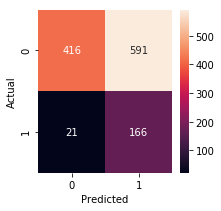

tpr          0.887701
fpr          0.586892
accuracy     0.487437
precision    0.219287
recall       0.887701
F score      0.351695
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



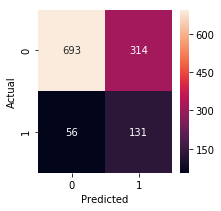

tpr          0.700535
fpr          0.311817
accuracy     0.690117
precision    0.294382
recall       0.700535
F score      0.414557
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



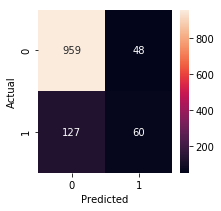

tpr          0.320856
fpr          0.047666
accuracy     0.853434
precision    0.555556
recall       0.320856
F score      0.406780
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.7 

Accuracy Metrics: 



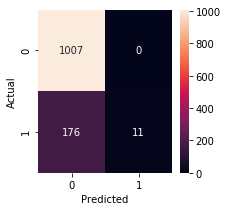

tpr          0.058824
fpr          0.000000
accuracy     0.852596
precision    1.000000
recall       0.058824
F score      0.111111
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.8 

Accuracy Metrics: 



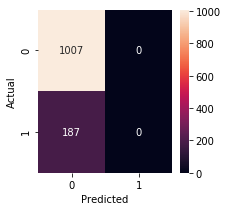

tpr          0.000000
fpr          0.000000
accuracy     0.843384
precision         NaN
recall       0.000000
F score           NaN
Name: 1, dtype: float64




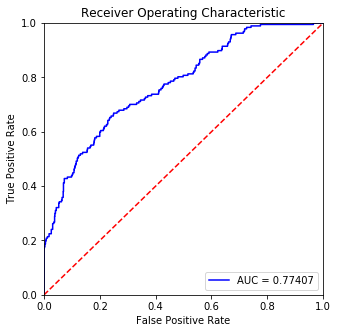

---------------Model:  xgb_pred --------------

CV Results on the training data data:
GCV best score:  0.9130713918849512 
GCV best parameters:  {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0} 

Results on the hold-out test data:

Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



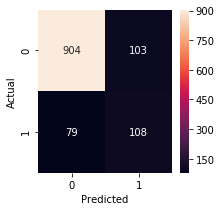

tpr          0.577540
fpr          0.102284
accuracy     0.847571
precision    0.511848
recall       0.577540
F score      0.542714
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



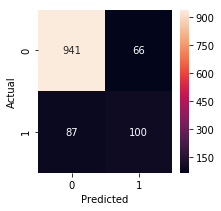

tpr          0.534759
fpr          0.065541
accuracy     0.871859
precision    0.602410
recall       0.534759
F score      0.566572
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



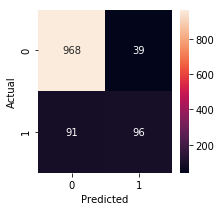

tpr          0.513369
fpr          0.038729
accuracy     0.891122
precision    0.711111
recall       0.513369
F score      0.596273
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.7 

Accuracy Metrics: 



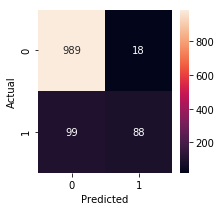

tpr          0.470588
fpr          0.017875
accuracy     0.902010
precision    0.830189
recall       0.470588
F score      0.600683
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.8 

Accuracy Metrics: 



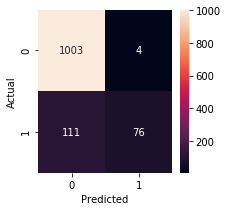

tpr          0.406417
fpr          0.003972
accuracy     0.903685
precision    0.950000
recall       0.406417
F score      0.569288
Name: 1, dtype: float64




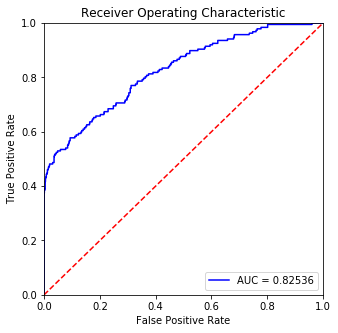

In [66]:
# This section evaluates the models for new artists
    for key, value in model_predictions.items():
        print('---------------Model: ', key, "--------------\n")
        print('CV Results on the training data data:')
        print('GCV best score: ', value[1], "")
        print('GCV best parameters: ', value[2], "\n")
        print('Results on the hold-out test data:\n')
        for i in [0.4, 0.5, 0.6, 0.7, 0.8]:
        #for i in [0.4]:
            print("Evaluating with different thresholds\n")
            print('threshold: ', i, "\n")
            print('Accuracy Metrics: \n')
            get_metrics(value[0], i)
            print("\n")
        plot_roc(value[0], i)
